<a href="https://colab.research.google.com/github/ChefKeff/1MD032_IntelInter/blob/main/main_notebook_inf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pvlib

     |████████████████████████████████| 27.5 MB 17.9 MB/s 


In [2]:
import os
import pandas as pd
import numpy as np
from pvlib import location, irradiance, pvsystem, inverter
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

my_path = '/content/drive/MyDrive/SKOLA/UU/INF PROJECT/Project - Infrastructure Systems/Progg/'   # Niklas Drive
#my_path = '/content/drive/MyDrive/Project - Infrastructure Systems/Progg/'                       # Dolles Drive
#my_path = '/content/dirve/MyDrive/Progg/'                   #Pontus drive


Mounted at /content/drive


In [4]:
df_data = pd.read_csv(my_path + 'model_data.csv')

# Define location parameters
lat, lon = 57.033110, 12.382547 # Coordinates to Varberg
tz = 'UTC'
site = location.Location(lat,lon,tz=tz)

df_dates = pd.date_range(start = str(df_data["Year"][0]) + "-" + str(df_data["Month"][0]) + "-" + str(df_data["Day"][0]) + " " + str(df_data["HourOfDay"][0]) + ":00:00", 
                         end = str(df_data["Year"].iloc[-1]) + "-" + str(df_data["Month"].iloc[-1]) + "-" + str(df_data["Day"].iloc[-1]) + " " + str(df_data["HourOfDay"].iloc[-1]) + ":00:00",
                         freq = "1H",
                         tz=site.tz)

df_wp = pd.DataFrame({'wp': df_data["Windfarm1"]}).set_index(pd.to_datetime(df_dates.values, utc = True))
df_irr = pd.DataFrame({'dhi': df_data["DHI"], 'dni': df_data["DNI"], 'ghi': df_data["GHI"]}).set_index(pd.to_datetime(df_dates.values, utc = True))
df_spot_price = pd.DataFrame({'spot': df_data["Price [SEK/MWh]"]/1000}).set_index(pd.to_datetime(df_dates.values, utc = True)) # SEK/kWh


In [5]:
def get_poa(site_location, date, irr, tilt, surface_azimuth):
    #clearsky = site_location.get_clearsky(date) # Get the clear sky irradiance
    solar_position = site_location.get_solarposition(times=date)
    POA_irradiance = irradiance.get_total_irradiance(surface_tilt=tilt,
                                                     surface_azimuth=surface_azimuth,
                                                     dni=irr["dni"],
                                                     ghi=irr["ghi"],
                                                     dhi=irr["dhi"],
                                                     solar_zenith=solar_position['apparent_zenith'],
                                                     solar_azimuth=solar_position['azimuth'],
                                                     albedo=0.2)
    return pd.DataFrame({'POA': POA_irradiance['poa_global']})

# Define module and inverter properties
module_parameters = {'pdc0': 100, 'gamma_pdc': -0.004}
inverter_parameters = {'pdc0': 100, 'eta_inv_nom': 0.96}
system = pvsystem.PVSystem(module_parameters=module_parameters,
                           inverter_parameters=inverter_parameters)


In [ ]:
# Define system properties
solar_zenith = 0
panel_tilt = np.linspace(0, 180,30)      # To be optimized
azimuth = np.linspace(0, 360,30)         # To be optimized

Getting the Solar Production for the year for Varberg


In [ ]:
eff = 0.17   

sun_res = pd.DataFrame([], columns = ['Tilt', 'Azimuth', 'Capacity [kWh]'])
best = pd.DataFrame([], columns = ['Tilt', 'Azimuth', 'Capacity [kWh]'])
best['Tilt'] = 0
best['Azimuth'] = 0
best['Capacity [kWh]'] = 0


for tilt in panel_tilt:
  azi_count = 0
  for azi in azimuth:

      df_poa = get_poa(site, df_dates, df_irr, tilt, azi) # We get this in W/m^2

      pv = (df_poa*2*eff) # PV power output. Since df_poa is given in W/m^2, multiplying by area (m^2), we can get power output in Watts
      pv = pv.to_numpy()

      sun_res = sun_res.append({'Tilt': round(tilt,3), 'Azimuth': round(azi,3), 'Capacity [kWh]': np.sum(np.ravel(pv))}, ignore_index = True) 

print(best)

Empty DataFrame
Columns: [Tilt, Azimuth, Capacity [kWh]]
Index: []


In [ ]:
print(sun_res['Capacity [kWh]'].idxmax())
print(sun_res.iloc[1950])

1950
Tilt                  34.545000
Azimuth              181.818000
Capacity [kWh]    391164.543099
Name: 1950, dtype: float64


Absolut max pv output vid tilt = 34.545 och azz = 181.818

In [ ]:
eff = 0.17   

sun_res = pd.DataFrame([], columns = ['Tilt', 'Azimuth', 'Capacity [kWh]'])

#for tilt in panel_tilt:
tilt = 34.545
azi_count = 0
for azi in azimuth:

    df_poa = get_poa(site, df_dates, df_irr, tilt, azi) # We get this in W/m^2

    pv = (df_poa*2*eff) # PV power output. Since df_poa is given in W/m^2, multiplying by area (m^2), we can get power output in Watts
    pv = pv.to_numpy()

    sun_res = sun_res.append({'Tilt': round(tilt,3), 'Azimuth': round(azi,3), 'Capacity [kWh]': np.sum(np.ravel(pv))}, ignore_index = True) 

sun_res2 = pd.DataFrame([], columns = ['Tilt', 'Azimuth', 'Capacity [kWh]'])

for tilt in panel_tilt:
  azi = 181.818
  df_poa = get_poa(site, df_dates, df_irr, tilt, azi) # We get this in W/m^2

  pv = (df_poa*2*eff) # PV power output. Since df_poa is given in W/m^2, multiplying by area (m^2), we can get power output in Watts
  pv = pv.to_numpy()

  sun_res2 = sun_res2.append({'Tilt': round(tilt,3), 'Azimuth': round(azi,3), 'Capacity [kWh]': np.sum(np.ravel(pv))}, ignore_index = True) 

In [6]:
optimal = get_poa(site, df_dates, df_irr, 34.545, 181.818)

In [7]:
plt.rcParams['figure.figsize'] = [13, 7.5]
plt.subplot(121)
plt.plot(sun_res2['Tilt'], sun_res2['Capacity [kWh]'])
plt.ylabel('Energy production')
plt.xlabel('Tilt')
plt.subplot(122)
plt.plot(sun_res["Azimuth"], sun_res["Capacity [kWh]"])
plt.ylabel('Energy production')
plt.xlabel('Azimuth')
plt.show()

NameError: ignored

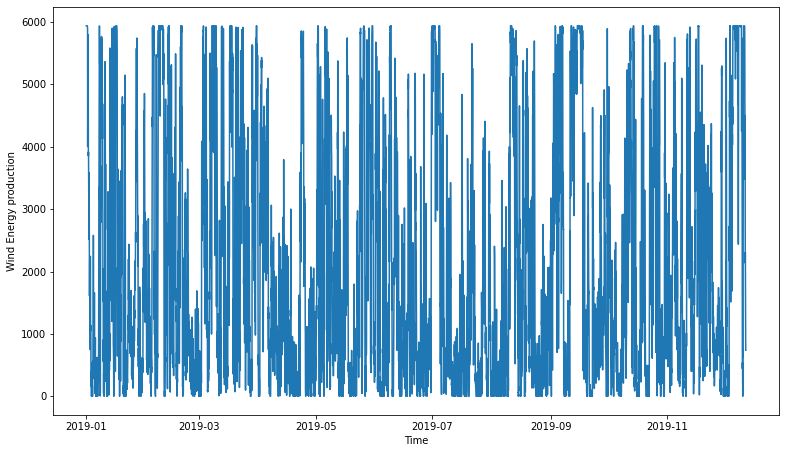

In [9]:
plt.subplot(121)
plt.plot(optimal["POA"])
plt.ylabel('Solar Energy production')
plt.xlabel('Time')
plt.subplot(122)
plt.plot(df_wp['wp'])
plt.ylabel('Wind Energy production')
plt.xlabel('Time')
plt.show()

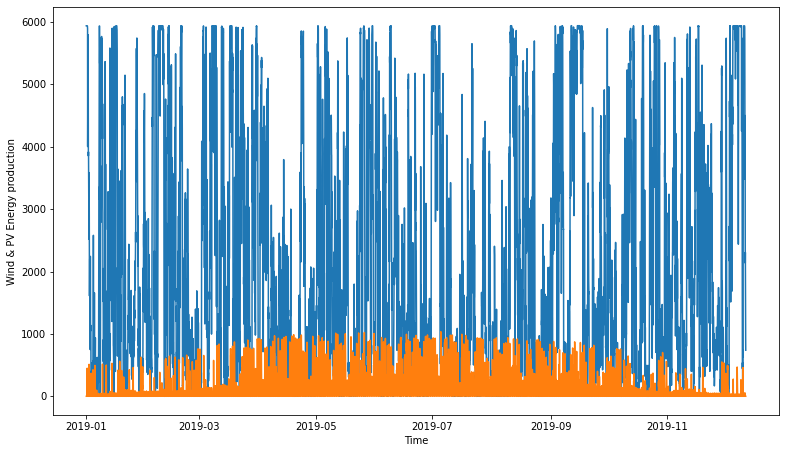

In [ ]:
plt.plot(df_wp['wp'])
plt.plot(optimal["POA"])
plt.ylabel('Wind & PV Energy production')
plt.xlabel('Time')
plt.show()

For generating a large heat map


In [ ]:
limit = max(df_wp['wp'])                # Define transformer limit
max_curtail = 5                         # Maximum allowed curtailment in percent [%]
eff = 0.17                              # Efficiency of PV system

# Declare dataframes for saving
capacity_results = pd.DataFrame([], columns = ['Tilt', 'Azimuth', 'Area [M2]', 'Capacity [kWh]', 'Tot curt'])

wind = df_wp["wp"].to_numpy()

for tilt in panel_tilt:
    azi_count = 0
    for azi in azimuth:
        curtailed = 0
        latest_curt = 0
        area = 30000 # In m^2

        df_poa = get_poa(site, df_dates, df_irr, tilt, azi) # We get this in W/m^2

        pv = (df_poa*area*eff) # PV power output. Since df_poa is given in W/m^2, multiplying by area (m^2), we can get power output in Watts
        pv = pv.to_numpy()

        while curtailed <= max_curtail:
            latest_curt = curtailed
            pv_output = (np.ravel(df_poa)*area*eff) / 1000
            curtailment = np.minimum(np.repeat(limit, len(pv)) - ((wind) + pv_output), np.repeat(0, len(pv)))
            curtailed = 100*np.abs(np.sum(curtailment))/((np.sum(wind)+np.sum(pv_output))-np.sum(curtailment))
            # curtailed = (np.abs(np.sum(curtailment)) + np.sum(wind)) / (limit * len(pv))
            area = area + 50            # Might be too or too litte to add 10 m^2

        #capacity_results = capacity_results.append({'Tilt': round(tilt,3), 'Azimuth': round(azi,3), 'Area [M2]': (area-10), 'Capacity [kWh]': np.sum(pv_output), 'Tot curt': latest_curt}, ignore_index = True) denna va den gamlar
        capacity_results = capacity_results.append({'Tilt': round(tilt,3), 'Azimuth': round(azi,3), 'Area [M2]': area, 'Capacity [kWh]': np.sum(pv_output), 'Tot curt': latest_curt}, ignore_index = True) #Denna skapar heatmap med prod/area

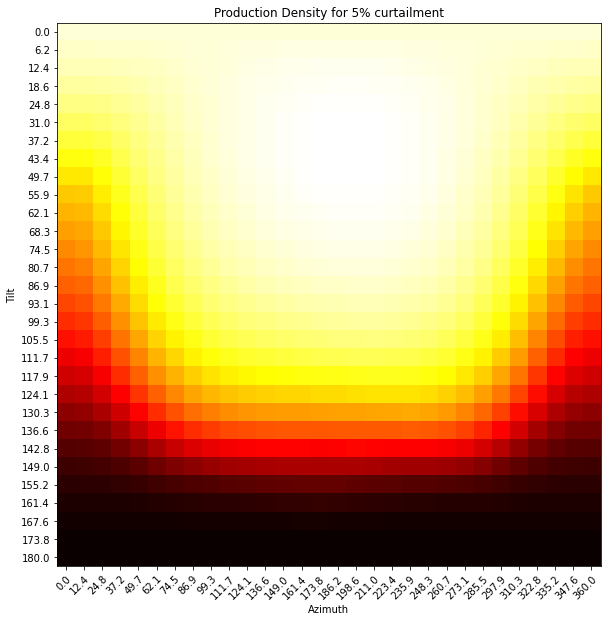

In [ ]:
area_list = []
sub_arr = []

for index in range(len(panel_tilt)**2):
  if len(sub_arr) is not len(panel_tilt):
    sub_arr.append(capacity_results['Area [M2]'].iloc[index])
  else:
    area_list.append(sub_arr)
    sub_arr = []
    curr_tilt = capacity_results['Tilt'].iloc[index]
    sub_arr.append(capacity_results['Area [M2]'].iloc[index])


area_list.append(sub_arr)

area_np = np.array(area_list)

color_map = plt.cm.get_cmap('hot').reversed() #Gamla heatmap för minsta area

plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
im = ax.imshow(area_np, cmap = color_map)

# Setting the labels
ax.set_xticks(np.arange(len(azimuth)))
ax.set_yticks(np.arange(len(panel_tilt)))
# labeling respective list entries
ax.set_xticklabels(azimuth.round(decimals=1, out=None))
ax.set_yticklabels(panel_tilt.round(decimals=1, out=None))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Creating text annotations by using for loop
#for i in range(len(panel_tilt)):
#    for j in range(len(azimuth)):
#        text = ax.text(j, i, f'{(100+curt_np[i, j]).round(decimals=2, out=None)}% \n {area_np[i,j]} \n Area M2',
#                       ha="center", va="center")

ax.set_title(f'Production Density for {max_curtail}% curtailment')
plt.ylabel("Tilt")
plt.xlabel("Azimuth")
plt.show()

For generating a smaller heat map

In [ ]:
# Define system properties
solar_zenith = 0
panel_tilt = np.linspace(15, 55,10)      # To be optimized
azimuth = np.linspace(140, 250,10)         # To be optimized

In [ ]:
limit = max(df_wp['wp'])                # Define transformer limit
max_curtail = 10                         # Maximum allowed curtailment in percent [%]
eff = 0.17                              # Efficiency of PV system

# Declare dataframes for saving
capacity_results = pd.DataFrame([], columns = ['Tilt', 'Azimuth', 'Area [M2]', 'Capacity [kWh]', 'Tot curt'])

wind = df_wp["wp"].to_numpy()

for tilt in panel_tilt:
    azi_count = 0
    for azi in azimuth:
        curtailed = 0
        latest_curt = 0
        area = 40000 # In m^2

        df_poa = get_poa(site, df_dates, df_irr, tilt, azi) # We get this in W/m^2

        pv = (df_poa*area*eff) # PV power output. Since df_poa is given in W/m^2, multiplying by area (m^2), we can get power output in Watts
        pv = pv.to_numpy()

        while curtailed <= max_curtail:
            latest_curt = curtailed
            pv_output = (np.ravel(df_poa)*area*eff) / 1000
            curtailment = np.minimum(np.repeat(limit, len(pv)) - ((wind) + pv_output), np.repeat(0, len(pv)))
            curtailed = 100*np.abs(np.sum(curtailment))/((np.sum(wind)+np.sum(pv_output))-np.sum(curtailment))
            area = area + 2            # Might be too or too litte to add 10 m^2

        #capacity_results = capacity_results.append({'Tilt': round(tilt,3), 'Azimuth': round(azi,3), 'Area [M2]': (area-10), 'Capacity [kWh]': np.sum(pv_output), 'Tot curt': latest_curt}, ignore_index = True) denna va den gamlar
        capacity_results = capacity_results.append({'Tilt': round(tilt,3), 'Azimuth': round(azi,3), 'Area [M2]': area, 'Capacity [kWh/M2]': (np.sum(pv_output) / area).round(decimals=2, out=None), 'Tot curt': latest_curt}, ignore_index = True) #Denna skapar heatmap med prod/area

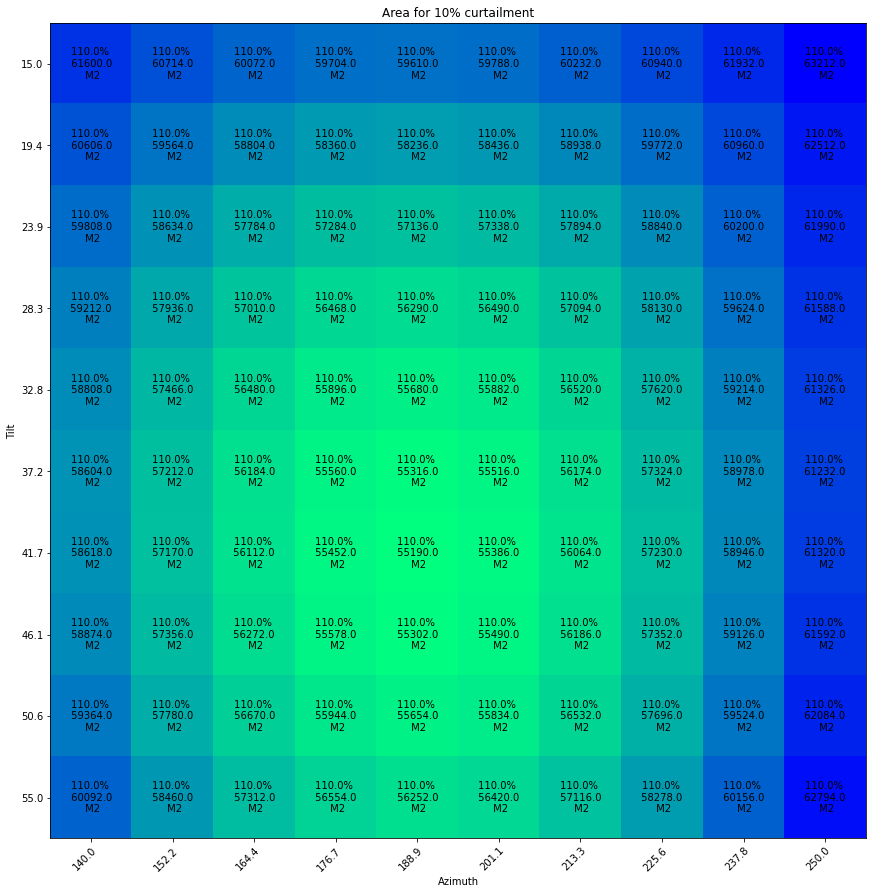

In [ ]:
cap_list = []
curt_list = []
sub_arr = []
sub_curt = []

for index in range(len(panel_tilt)**2):
  if len(sub_arr) is not len(panel_tilt):
    sub_arr.append(capacity_results['Area [M2]'].iloc[index])
    sub_curt.append(capacity_results['Tot curt'])
  else:
    cap_list.append(sub_arr)
    curt_list.append(sub_curt)
    sub_arr = []
    curr_tilt = capacity_results['Tilt'].iloc[index]
    sub_arr.append(capacity_results['Area [M2]'].iloc[index])
    sub_curt.append(capacity_results['Tot curt'])


cap_list.append(sub_arr)
curt_list.append(sub_curt)

cap_np = np.array(cap_list)
curt_np = np.array(sub_curt)

#color_map = plt.cm.get_cmap('winter').reversed() #Gamla heatmap för minsta area
color_map = plt.cm.get_cmap('winter').reversed() #Heat map för största prod/area 

plt.rcParams['figure.figsize'] = [15, 15]
fig, ax = plt.subplots()
im = ax.imshow(cap_np, cmap=color_map)

# Setting the labels
ax.set_xticks(np.arange(len(azimuth)))
ax.set_yticks(np.arange(len(panel_tilt)))
# labeling respective list entries
ax.set_xticklabels(azimuth.round(decimals=1, out=None))
ax.set_yticklabels(panel_tilt.round(decimals=1, out=None))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Creating text annotations by using for loop
for i in range(len(panel_tilt)):
    for j in range(len(azimuth)):
        text = ax.text(j, i, f'{(100+curt_np[i, j]).round(decimals=2, out=None)}% \n {(cap_np[i,j])} \n M2',
                       ha="center", va="center")

ax.set_title(f'Area for {max_curtail}% curtailment')
plt.ylabel("Tilt")
plt.xlabel("Azimuth")
plt.show()

Get energy density for set area


In [ ]:
# Define system properties
solar_zenith = 0
panel_tilt = np.linspace(0, 180,30)      # To be optimized
azimuth = np.linspace(0, 360,30)         # To be optimized

In [ ]:
limit = max(df_wp['wp'])                # Define transformer limit
max_curtail = 10                         # Maximum allowed curtailment in percent [%]
eff = 0.17                              # Efficiency of PV system
area = 30000 # In m^2

# Declare dataframes for saving
capacity_results = pd.DataFrame([], columns = ['Tilt', 'Azimuth', 'Area [M2]', 'Capacity [kWh]', 'Tot curt'])

wind = df_wp["wp"].to_numpy()
azi = 181.8181

for tilt in panel_tilt:
        curtailed = 0
        latest_curt = 0

        df_poa = get_poa(site, df_dates, df_irr, tilt, azi) # We get this in W/m^2

        pv = (df_poa*area*eff) # PV power output. Since df_poa is given in W/m^2, multiplying by area (m^2), we can get power output in Watts
        pv = pv.to_numpy()


        pv_output = (np.ravel(df_poa)*area*eff) / 1000
        curtailment = np.minimum(np.repeat(limit, len(pv)) - ((wind) + pv_output), np.repeat(0, len(pv)))
        curtailed = 100*np.abs(np.sum(curtailment))/((np.sum(wind)+np.sum(pv_output))-np.sum(curtailment))

        #capacity_results = capacity_results.append({'Tilt': round(tilt,3), 'Azimuth': round(azi,3), 'Area [M2]': (area-10), 'Capacity [kWh]': np.sum(pv_output), 'Tot curt': latest_curt}, ignore_index = True) denna va den gamlar
        capacity_results = capacity_results.append({'Tilt': round(tilt,3), 'Azimuth': round(azi,3), 'Area [M2]': area, 'Capacity [kWh/M2]': (np.sum(pv_output) / area).round(decimals=2, out=None), 'Tot curt': curtailed}, ignore_index = True) #Denna skapar heatmap med prod/area

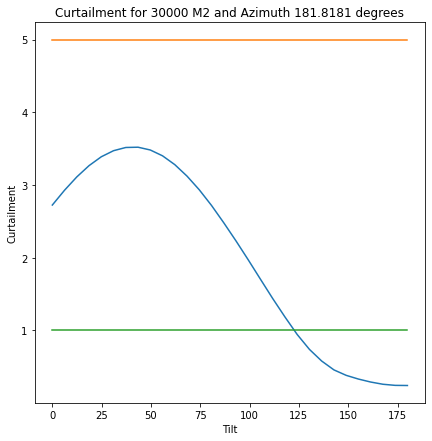

In [ ]:
plt.rcParams['figure.figsize'] = [7, 7]
plt.plot(capacity_results['Tilt'], capacity_results['Tot curt'])
plt.plot(capacity_results['Tilt'], [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5])
plt.plot(capacity_results['Tilt'], [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
plt.title(f'Curtailment for {area} M2 and Azimuth {azi} degrees')
plt.ylabel('Curtailment')
plt.xlabel('Tilt')
plt.show()

Some unused stuff below

In [ ]:
varberg_temp = pd.read_csv(my_path + "new_temp1.csv", sep=";", na_filter=False)
temp_list = []

i = 0
while i < 1033:
  k = 0
  mean_temp = (float(varberg_temp['Lufttemperatur'].iloc[i]) + float(varberg_temp['Lufttemperatur'].iloc[i+1]) + float(varberg_temp['Lufttemperatur'].iloc[i+2]))/3
  while k < 24:
    if str(type(varberg_temp['Lufttemperatur'].iloc[i])) == "str":
      temp_list.append((float(varberg_temp['Lufttemperatur'].iloc[i])))
    else:
      temp_list.append((varberg_temp['Lufttemperatur'].iloc[i]))
    k += 1
  i += 3

varberg_temp_np = np.array(temp_list)